In [317]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using MPSKit
using TensorKit
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")



generate_random_quantum_circuit (generic function with 1 method)

Definition of the relevant transformation functions in the notebook below:

Transform the full tensornetwork to the tree structure by sequentially applying the transformation defined in taken path

But first - redefinition of all the relevant functions

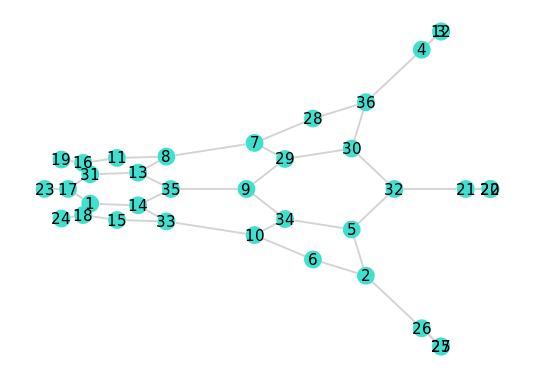

TN_tree_transform_approximate (generic function with 2 methods)

In [318]:
"""
Load in the TN and the graph representation together with the relevant mapping
dictionaries
"""



TN, graph, tv_map, ie_map, weighted_edge_list, ei_map = FileIO.load("transport variables/export_to_alphazero.jld2","A2")
taken_path = FileIO.load("transport variables/taken_path.jld2","taken_path")

# plot the graph structure of the initial graph
display(gplot(graph, nodelabel=[i for i in 1:nv(graph)], layout=spectral_layout))

function replace_index(tensor, replace_inds, new_inds)

    """
    Functionality which can take in a Tenet.Tensor and replace the list of 
    indices in replace_inds with the indices in new_inds:
    replace_inds[i] => new_inds[i]
    """

    mapping = Dict(zip(replace_inds, new_inds))
    current_inds = inds(tensor)
    ids = []
    for id in current_inds
        if id in replace_inds
            push!(ids, mapping[id])
        else
            push!(ids, id)
        end
    end
    new_tensor = Tenet.Tensor(tensor.data, [ids...])
    return new_tensor
end


function extract_partial_tn_loop(TN, index_cycle, printing = false)

    """
    Based on the index in the index cycle crop out a part of the tensor network
    and return this local LOOP-TensorNetwork.
    """

    tensors_in_loop = collect(Set([tensor for id in index_cycle for tensor in Tenet.select(TN, Symbol(id))])) #correct orderding of variable definitions

    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end
        
    return current_tn
end



function generate_unique_symbols()

    """
    Function which generates a list of new symbols for index replacing capability
    """
    new_symbols = [Symbol(i) for i in 1000:1500]
   
    return new_symbols
  
end


function create_index_isomorphismgroup(size_index1, size_index2, indices)
    n = size_index1*size_index2
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (size_index1, size_index2, n))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [(indices...)])
    return identity_isomorphism
end


function create_index_isomorphismsplit(propagation_size, cut_size, new_indices, propagation_index)
    size_id_to_tensor = convert(Int64, propagation_size/cut_size)
    size_loop_part = cut_size
    n = propagation_size
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (propagation_size, size_id_to_tensor, size_loop_part))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [propagation_index, new_indices...])
    return identity_isomorphism
end

function collect_tensors_along_loop(loop_tn, index_cycle, index_to_cut)

    """
    Funtion whcih sequentially walks along the index cycle in the correct order
    loop and selects the relevant tensors.
    Return a list of tensors which is correctly ordered along the loop.
    """

    global start_tensor
    global end_tensor

    connectedtensors = Tenet.select(loop_tn, index_to_cut)
    firstsymbol = index_cycle[1]
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end

    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != connecting_id[1], index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
    
    return tensors_ordered_loop
end


function new_node_cycle(node_cycle::Vector{Int}, edge_to_cut::Tuple{Int, Int})

    """
    Put the node cycle in the correct ordering which places the node cycle
    in the correct form the extract the MPS.
    """
    
    for i in 1:length(node_cycle)
        node_perm = circshift( node_cycle, i-1)
        first_index = findfirst(x -> x == edge_to_cut[1], node_perm)
        second_index = findfirst(x -> x == edge_to_cut[2], node_perm)
        if sort([first_index, second_index]) == [1, length(node_cycle)]
            node_cycle = node_perm
            break
        end
    end
    return node_cycle
end

function calculate_site_averaged_etanglement(mps)

    """
    Function to check what happens to the entanglement when we compress the MPS
    """
    entropies = []
    for i in 1:length(mps)
        push!(entropies, sum(real, entropy(mps,i)))
    end
    site_average_entropy = sum(entropies)/length(mps)
    return site_average_entropy
end




function compress_Tenet_MPS(TenetMPS, physical_order, chi_max, printing = false)

    """
    Function which takes in a TenetMPS, a order of the physical indices,
    and a max allowable chi_max. Compresses the MPS using a conversion to MPSKit
    and DMRG compression. After compression reconverts to TenetMPS and returns
    the compressed MPS.
    """

    Tens = Tenet.tensors(TenetMPS)
    additional_fake_indices_of_size1 = [Symbol("fake1"), Symbol("fake2")]
    t_compat = []

    """
    Make the MPS Network compatible with the FiniteMPS from within MPSKit.jl
    """

    left_index = physical_order[1]
    i = 1
    for t in Tens
        if length(inds(t)) == 2
            new_t = Tenet.Tensor(reshape(t.data, (size(t.data)[1], size(t.data)[2], 1)), (inds(t)..., additional_fake_indices_of_size1[i]))
            i += 1
            push!(t_compat, new_t)
            continue
        end
        push!(t_compat, t)
    end
    
    TN_compat = Tenet.TensorNetwork(t_compat)


    global ids 

    T_ordered = []
    inds_connection = []

    for i in 1:length(Tenet.tensors(TN_compat))
        if i == 1
            for t in Tenet.tensors(TN_compat)
                ids = inds(t)
                if !isempty(intersect(inds(t), [left_index]))
                    push!(T_ordered, t)
                    break
                end
            end
        end
        for t in Tenet.tensors(TN_compat)
            if t ∉ T_ordered
                if !isempty(intersect(inds(t), ids))
                    push!(inds_connection, intersect(inds(t), ids)[1])

                    push!(T_ordered, t)
                    ids = inds(t)
                end
            end
        end
    end
    pushfirst!(inds_connection, additional_fake_indices_of_size1[1])
    push!(inds_connection, additional_fake_indices_of_size1[2])
    inds_connection = [id for id in inds_connection]
    first = [inds_connection[1], physical_order[1], inds_connection[2]]
    last = [inds_connection[end-1], physical_order[end], inds_connection[end]]

    permutation_list = [[inds_connection[i], physical_order[i], inds_connection[i+1]] for i in 2:length(physical_order)-1]
    pushfirst!(permutation_list, first)
    push!(permutation_list, last)


    extracted_maps = []
    approximate_extracted_maps = []
    approximate_sizes_list = []

    """
    Extract the TensorKit Maps
    """

    for (i, t) in enumerate(T_ordered)
        t = permutedims(t, permutation_list[i])
        push!(extracted_maps, TensorMap(t.data, ℂ^(size(t, inds(t)[1])) ⊗ ℂ^(size(t, inds(t)[2])), ℂ^(size(t, inds(t)[3]))))

        # Always keep the correct physical size
        # Keep the bond dimension to the chi_max value or smaller
        # take min(chi_max, needed dim) in the virtual connecting spaces
        
        
        push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
                                                                    (size(t, inds(t)[2])), 
                                                                    minimum([chi_max, size(t, inds(t)[3])])),
                                                                    ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
                                                                     ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])])))
    end

    extracted_maps = [map for map in extracted_maps]
    approximate_extracted_maps = [map for map in approximate_extracted_maps]
    
    mps_exact = FiniteMPS(extracted_maps)
    mps_approximate = FiniteMPS(approximate_extracted_maps)
    
    if printing == true 
        println("Exact MPS = \n" , mps_exact)
        println("Approximate MPS = \n" , mps_approximate)
    end

    """
    Run the compression algorithm 
    """

    # Create a DMRG algorithm instance
    alg = DMRG(;  # Choose DMRG (1-site) for this example
            maxiter = 40,  # Maximum number of iterations
            verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
            tol = 1e-16
            )
    
    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(mps_exact)), physicalspace(mps_exact, i))) for i in 1:length(mps_exact)]) # corresponding identity operator as an MPO
    mps_new, = approximate(mps_approximate, (I_MPO, mps_exact), alg)
    exact_entropy = calculate_site_averaged_etanglement(mps_exact)
    compressed_entropy = calculate_site_averaged_etanglement(mps_new)
    println("original site_average_entropy = ", exact_entropy)
    println("compressed site_average_entropy = ", compressed_entropy)



    """
    Reconvert to Tenet.TensorNetwork compatible format
    """

    new_tenet_tensors = []
    for i in 1:length(mps_new)
        if i == length(mps_new)
            shaped_data = reshape(mps_new.AC[i].data, (approximate_sizes_list[i]))
            new_t = Tenet.Tensor(shaped_data, permutation_list[i])
            push!(new_tenet_tensors, new_t)
            break
        end

        shaped_data = reshape(mps_new.AL[i].data, (approximate_sizes_list[i]))
        new_t = Tenet.Tensor(shaped_data, permutation_list[i])
        push!(new_tenet_tensors, new_t)
    end

    TenetMPS = Tenet.TensorNetwork(new_tenet_tensors)

    for fake_index in additional_fake_indices_of_size1
        #println("used fake = ", fake_index)
        t_old = Tenet.select(TenetMPS, fake_index)[1]
        # case where it is an edge tensor
        if length(inds(t_old)) == 2
            id_keep = setdiff(inds(t_old), [fake_index])[1]
            t_new = Tenet.Tensor(reshape(t_old.data, size(t_old, id_keep)), [id_keep])
            pop!(TenetMPS, t_old)
            push!(TenetMPS, t_new)
        end
        # case where it is a bulk tensor
        if length(inds(t_old)) == 3
            id_keep = setdiff(inds(t_old), [fake_index])
            t_new = Tenet.Tensor(reshape(t_old.data, (size(t_old, id_keep[1]), size(t_old, id_keep[2]))), (id_keep))
            pop!(TenetMPS, t_old)
            push!(TenetMPS, t_new)
        end
    end
    return TenetMPS

end


function loop_and_QRED_mps_overlap(loop, physical_index_ordering, chi_max, printing = false, plotting = false)

    """ 
    define original loop and use it to compute a QRED => MPS
    => return the mps tensor network and provide a local fidelity analysis
    """ 

    loop_net = deepcopy(loop)
    if plotting == true
        drawing1 = Makie.plot(loop_net, node_color=[:darkred for i in 1:length(tensors(loop_net))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    virtual = [Symbol("v$i") for i in 1:100] 
    contracted_loop = Tenet.contract(loop_net)
    global prop_id

    """
    Transform the loop TensorNetwork into an exact MPS tensor
    """

    T_QR1 = []
    R = contracted_loop
    connection_indices = virtual[1:length(inds(R))-1]
    for (i, index) in enumerate(physical_index_ordering)
        if i == length(physical_index_ordering)
            push!(T_QR1, R)
            break
        end
        if i == 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index], virtualind=virtual[i])
            push!(T_QR1, Q)
            global prop_id = setdiff(inds(Q), [index])[1]
        end
        if i > 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index, prop_id], virtualind=virtual[i])
            push!(T_QR1, Q)
            prop_id = setdiff(inds(Q), [index, prop_id])[1]
        end
    end

    # define tensor networks 
    loop_net = deepcopy(loop)
    mps_net = Tenet.TensorNetwork(T_QR1)


    """
    Convert TenetMPS to MPSKit MPS --> Apply approximation function
    """

    mps_net = compress_Tenet_MPS(mps_net, physical_index_ordering, chi_max, true)
    tens_tnet = vcat(Tenet.tensors(loop_net), Tenet.tensors(mps_net))
    t_net_full = Tenet.TensorNetwork(tens_tnet)
    contracted_loop = (Tenet.contract(loop_net))
    contracted_Qr = (Tenet.contract(mps_net))
    
    if plotting == true
        drawing1 = Makie.plot(t_net_full, node_color=[:darkred for i in 1:length(tensors(t_net_full))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    """
    FIDELITY ANALYSIS
    """

    overlap_looploop = abs((Tenet.contract(contracted_loop, contracted_loop))[1])
    overlap_QrQr = abs((Tenet.contract(contracted_Qr, contracted_Qr))[1])
    overlap_full = abs((Tenet.contract(t_net_full))[1])
    if printing == true
        println(" ---------------- Local fidelity analysis ----------------- ")
        println("Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = ", abs(1- overlap_full^2/(overlap_looploop*overlap_QrQr)))
    end

    F =  overlap_full^2/(overlap_looploop*overlap_QrQr)

    return F, mps_net, connection_indices
end

function transform_to_MPS_QR_approximate(TN, edge_to_cut, node_cycle, chi_max, printing = false)

    """
    Function which takes in full tensor network, a cycle of tensor nodes
    and an edge to cut (tuple of two nodes).
    Returns the MPS like structured loop tensor network 
    defined by the node cycle.
    """
    
    # graph edge to tensor network edge
    index_to_cut = ei_map[edge_to_cut]
  
    # transform the node cycle to select the relevant tensors
    node_cycle = new_node_cycle(node_cycle, edge_to_cut)
   
    ### node cycle to index cycle
    tensors = [tv_map[node] for node in node_cycle]
    index_cycle = []

    for (i, tensor) in enumerate(tensors)
        if i < length(tensors)
            connection = intersect(inds(tensor), inds(tensors[i+1]))[1]
            push!(index_cycle, connection)
        end
        if i == length(tensors)
            connection = intersect(inds(tensor), inds(tensors[1]))[1]
            push!(index_cycle, connection)
        end
        index_cycle = [id for id in index_cycle]
    end
    loop_tn = extract_partial_tn_loop(TN, index_cycle, false)
    old_loop = deepcopy(loop_tn)
    index_cycle_to_remove = deepcopy(index_cycle)

    """
    Take care of the case where no dangling edges are found: 
    => add fake index with size 1
    Create a compatible loop TN
    """

    Tens = Tenet.tensors(loop_tn)
    additional_fake_indices_of_size1 = [Symbol("f$i") for i in 1:25]
    t_compat = []
    used_fakes = []
    z = 1
    for t in Tens
        if length(inds(t)) == 2
            new_t = Tenet.Tensor(reshape(t.data, (size(t.data)[1], size(t.data)[2], 1)), (inds(t)..., additional_fake_indices_of_size1[z]))
            push!(used_fakes, additional_fake_indices_of_size1[z])
            z += 1
            push!(t_compat, new_t)
            continue
        end
        push!(t_compat, t)
    end

    loop_tn = Tenet.TensorNetwork(t_compat)
    
    """
    collect tensors along the loop from start_tensor to end_tensor
    and reorganize_cycle for correct ordering along the loop
    """

    for (idx, index) in enumerate(index_cycle)
        if index == index_to_cut[1]
            index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
            break
        end
    end

    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), index_to_cut)

    """
    Extract the physical_index_ordering from the loop which allow the to create
    the correct MPS-structure based on the local LOOP-TensorNetwork.
    """

    physical_index_ordering = []
    for t in ordered_along_loop
        push!(physical_index_ordering, setdiff(inds(t), index_cycle_to_remove)[1])
    end
    physical_index_ordering = [id for id in physical_index_ordering]
    
  
    fidelity, mps_network, connection_indices = loop_and_QRED_mps_overlap(loop_tn, physical_index_ordering, chi_max, true, false)

    """
    Remove the fake indices
    """

    for fake_index in used_fakes
        #println("used fake = ", fake_index)
        t_old = Tenet.select(mps_network, fake_index)[1]
        # case where it is an edge tensor
        if length(inds(t_old)) == 2
            id_keep = setdiff(inds(t_old), [fake_index])[1]
            t_new = Tenet.Tensor(reshape(t_old.data, size(t_old, id_keep)), [id_keep])
            pop!(mps_network, t_old)
            push!(mps_network, t_new)
        end
        # case where it is a bulk tensor
        if length(inds(t_old)) == 3
            id_keep = setdiff(inds(t_old), [fake_index])
            t_new = Tenet.Tensor(reshape(t_old.data, (size(t_old, id_keep[1]), size(t_old, id_keep[2]))), (id_keep))
            pop!(mps_network, t_old)
            push!(mps_network, t_new)
        end
    end

    """
    replace the virtual indices in the MPS with the correct cycle indices
    old => new
    """

    for i in 1:length(connection_indices)
        replace!(mps_network, connection_indices[i] => index_cycle_to_remove[i])
    end

    return old_loop, mps_network, index_cycle_to_remove, fidelity
end

    
function TN_tree_transform_approximate(TN, taken_path, chi_max, plotting_final = false)

    """
    Function which takes in the TensorNetwork which contains_loops and a
    taken_path from the AlphaZero agent.
    Performs the deloopification by inserting exact MPS tree representations.
    """
    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    println("contracting initial network.....")

    with_loops = deepcopy(TN)
    T_loop = Tenet.contract(with_loops)

    """
    Walk the action path and apply each action sequentially on the 
    LOOP-TensorNetwork. Replace the loop with the tree.
    """

    for action in taken_path
        node_cycle = action[1]
        node_edge = action[2]
        loop, mps, removal_id, fidelity = transform_to_MPS_QR_approximate(TN, node_edge, node_cycle, chi_max, false)
        for id in removal_id[1:end-1]
            tens = Tenet.select(TN, id)
            for t in tens
                pop!(TN, t)
            end
        end
        for t in tensors(mps)
            push!(TN, t)
        end
        
    end

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    println("contracting tree-i-fied network.....")

    """
    Calculating the overlaps and fidelities.
    """

    tree = deepcopy(TN)
    T_tree = Tenet.contract(TN)
    overlap_looploop = abs((Tenet.contract(T_loop, T_loop))[1])
    overlap_treetree = abs((Tenet.contract(T_tree, T_tree))[1])
    overlap_full = abs((Tenet.contract(T_tree, T_loop))[1])

    println(" ---------------- GLOBAL FIDELITY ANALYSIS ------------ ")
    println("< Loop - state | Loop - state > = ", overlap_looploop)
    println("< Tree - state | Tree - state > = ", overlap_treetree)
    println("< Loop - state| Tree - state > = ", overlap_full)
    println("|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))

    return TN
end

In [319]:
# Run this to approximately contract a LOOP_TN
TN_tree_transform_approximate(TN, taken_path, 11, false)

TensorNetwork(#tensors=36, #inds=41)

Now a function to transform a TENET MPS -> MPSKit MPS -> Approximate MPSKit MPS -> Approximate Tenet MPS